# Deep Learning Fundamentals: Assignment 3
By Jack Hetherington

Due: 11:59pm, 07/11/2024

Objective: Compare the performance of SimpleRNN, LSTM and GRU models on their ability to predict stock prices with different lookback and lookforward time windows. 

* Lookback (M): 14, 30 and 60 days

* Lookforward (N): 1, 4 and 7 days

Data: Goolge (Alphabet Inc.) stock prices for 10 years

## 1. Import packages, data import and inspection

The objective of the study was to compare the lookback and lookforward horizons of the models. Therefore, there needs to be more data in the test set than what is available in the kaggle dataset. Therefore, ten years' of stock data is directly imported from the yfinance package. 

In [1]:
#import packages
import pprint
import pandas as pd
import numpy as np
import yfinance as yf
import itertools
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set display options for better visibility
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)       # Set a larger display width

In [2]:
#define ticker and date range
ticker = 'GOOG'
start_date = '2013-11-27'
end_date = '2023-11-27'

#Fetch data
data = yf.download(ticker, start=start_date, end=end_date)

#Save to CSV for later
data.to_csv('google_stock_data.csv')

print("Data saved to google_stock_data.csv")
print(data.columns)


[*********************100%***********************]  1 of 1 completed

Data saved to google_stock_data.csv
MultiIndex([('Adj Close', 'GOOG'),
            (    'Close', 'GOOG'),
            (     'High', 'GOOG'),
            (      'Low', 'GOOG'),
            (     'Open', 'GOOG'),
            (   'Volume', 'GOOG')],
           names=['Price', 'Ticker'])


In [3]:
#Set the display format to avoid scientific notation and limit to 2 decimal points
pd.set_option('display.float_format', '{:.2f}'.format)

#Calculate summary statistics for the specified columns
summary_stats = data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].describe().T
summary_stats['range'] = summary_stats['max'] - summary_stats['min']
summary_stats['n'] = summary_stats['count']
summary_stats['average'] = summary_stats['mean']
summary_stats['std_dev'] = summary_stats['std']

print(summary_stats[['min', 'max', 'average', 'std_dev', 'n']])

                       min          max     average     std_dev       n
Price     Ticker                                                       
Adj Close GOOG       24.50       150.34       67.84       36.83 2515.00
Close     GOOG       24.56       150.71       68.01       36.92 2515.00
High      GOOG       24.73       152.10       68.70       37.35 2515.00
Low       GOOG       24.31       149.89       67.29       36.49 2515.00
Open      GOOG       24.66       151.86       67.97       36.89 2515.00
Volume    GOOG   158434.00 223486554.00 34148993.02 19073681.64 2515.00


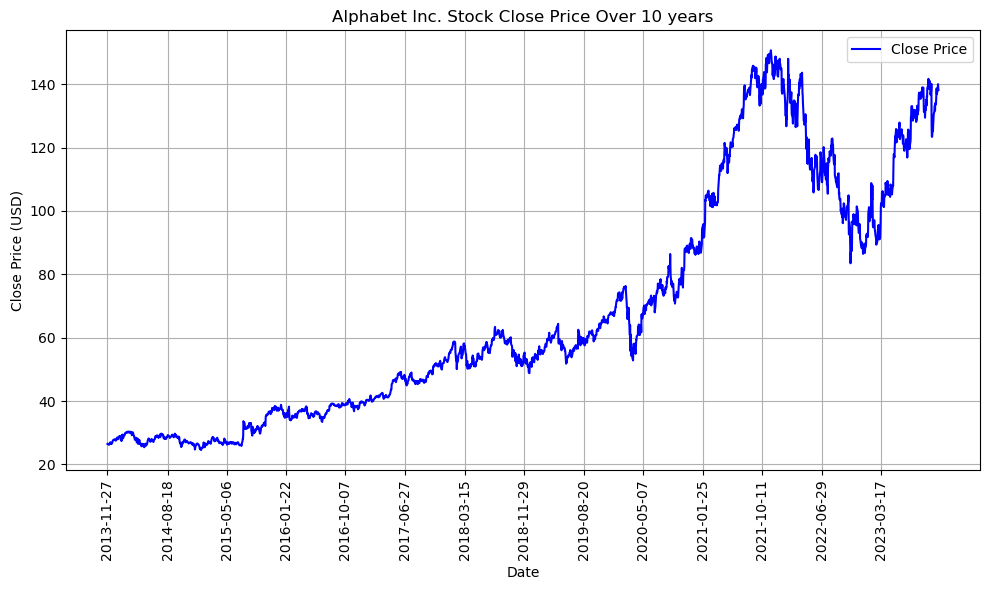

In [4]:
#Access the 'Close' price for 'GOOG' using MultiIndex
data['Close'] = data[('Close', 'GOOG')]
data.index = pd.to_datetime(data.index)

#Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title('Alphabet Inc. Stock Close Price Over 10 years')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(data.index[::180], rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

## 2. Pre-process data and define functions

In [5]:
#Reshape and scale the data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split data into train and test
train_size = int(len(scaled_prices) * 0.8)
train_scaled, test_scaled = scaled_prices[:train_size], scaled_prices[train_size:]

In [6]:
#Function to create sequences
def create_sequences(data, M, N):
    X, y = [], []
    for i in range(len(data) - M - N + 1):
        X.append(data[i:i+M, 0])
        y.append(data[i+M:i+M+N, 0])
    return np.array(X), np.array(y)

# Parameters
M_values = [14, 30, 60]  # Lookback/Days in the past
N_values = [1, 4, 7]     # Lookforward/Days in the future


## 3. Train models and evaluate performance

Hyperparameters:

* Activation function: Relu
* Optimiser: Adam
* Regularisation: Dropout 20%
* Loss function: Mean squared error
* Epochs: 100
* Batch size: 32

### 3.1. SimpleRNN

In [7]:
#Prepare storage for results
results_simple = {}

#Iterate over all combinations of M and N
for M, N in itertools.product(M_values, N_values):
    print(f"Training model with M={M}, N={N}...")
    
    #Ensure sufficient data exists for sequence generation
    if len(test_scaled) < M + N:
        print(f"Skipping M={M}, N={N} due to insufficient test data.")
        continue

    #Create sequences
    X_train, y_train = create_sequences(train_scaled, M, N)
    X_test, y_test = create_sequences(test_scaled, M, N)

    #Reshape for RNN input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Build the RNN model
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=(M, 1)),
        Dropout(0.2),  
        Dense(N)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #Track training time
    start_time = time.time()

    #Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    #Calculate training time
    training_time = time.time() - start_time
    
    #Evaluate the model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test)
    
    #Calculate MSE
    mse = np.mean((y_test_inv - predictions) ** 2)
    
    #Calculate MAE
    mae = mean_absolute_error(y_test_inv, predictions)
    
    #Calculate R-squared
    r_squared = r2_score(y_test_inv, predictions)
    
    #Get the number of parameters
    num_params = model.count_params()

    #Store results
    results_simple[(N, M)] = {
        'MSE': mse, 
        'MAE': mae,
        'R-squared': r_squared,
        'Training Time': training_time,
        'Num Parameters': num_params
    }

#Summary of results
print("\nPerformance Summary:")
results_simple_df = pd.DataFrame(results_simple)
print(results_simple_df)

Training model with M=14, N=1...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training model with M=14, N=4...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Training model with M=14, N=7...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training model with M=30, N=1...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training model with M=30, N=4...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training model with M=30, N=7...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training model with M=60, N=1...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training model with M=60, N=4...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training model with M=60, N=7...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Performance Summary:
                     1       4       7       1       4       7       1       4       7
                    14      14      14      30      30      30      60      60      60
MSE              14.38   19.84   31.26   12.99   17.66   25.40    8.42   16.39   27.82
MAE               3.12    3.47    4.46    2.93    3.30    3.

### 3.2. Long Short-Term Memory (LSTM)

In [8]:
#Prepare storage for results
results_LSTM = {}

#Iterate over all combinations of M and N
for M, N in itertools.product(M_values, N_values):
    print(f"Training model with M={M}, N={N}...")
    
    #Ensure sufficient data exists for sequence generation
    if len(test_scaled) < M + N:
        print(f"Skipping M={M}, N={N} due to insufficient test data.")
        continue

    #Create sequences
    X_train, y_train = create_sequences(train_scaled, M, N)
    X_test, y_test = create_sequences(test_scaled, M, N)

    #Reshape for LSTM input (3D: samples, time steps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Build the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(M, 1)),
        Dropout(0.2),  
        Dense(N)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #Track training time
    start_time = time.time()

    #Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    #Calculate training time
    training_time = time.time() - start_time
    
    #Evaluate the model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test)
    
    #Calculate MSE
    mse = np.mean((y_test_inv - predictions) ** 2)
    
    #Calculate MAE
    mae = mean_absolute_error(y_test_inv, predictions)
    
    #Calculate R-squared
    r_squared = r2_score(y_test_inv, predictions)
    
    #Get the number of parameters
    num_params = model.count_params()

    #Store results
    results_LSTM[(N, M)] = {
        'MSE': mse, 
        'MAE': mae,
        'R-squared': r_squared,
        'Training Time': training_time,
        'Num Parameters': num_params
    }

#Summary of results
print("\nPerformance Summary:")
results_LSTM_df = pd.DataFrame(results_LSTM)
print(results_LSTM_df)

Training model with M=14, N=1...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Training model with M=14, N=4...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Training model with M=14, N=7...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Training model with M=30, N=1...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Training model with M=30, N=4...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training model with M=30, N=7...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training model with M=60, N=1...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training model with M=60, N=4...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Training model with M=60, N=7...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Performance Summary:
                      1        4        7        1        4        7        1        4        7
                     14       14       14       30       30       30       60       60       60
MSE               12.89    24.55    28.43    11.71    20.73    29.60    14.38    22.17    33.08
MAE                2.83     3.86 

### 3.3. Gated Recurrent Unit (GRU)

In [9]:
#Prepare storage for results
results_GRU = {}

#Iterate over all combinations of M and N
for M, N in itertools.product(M_values, N_values):
    print(f"Training model with M={M}, N={N}...")
    
    #Ensure sufficient data exists for sequence generation
    if len(test_scaled) < M + N:
        print(f"Skipping M={M}, N={N} due to insufficient test data.")
        continue

    #Create sequences
    X_train, y_train = create_sequences(train_scaled, M, N)
    X_test, y_test = create_sequences(test_scaled, M, N)

    #Reshape for GRU input (3D: samples, time steps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    #Build the GRU model
    model = Sequential([
        GRU(50, activation='relu', input_shape=(M, 1)),
        Dropout(0.2),  
        Dense(N)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Track training time
    start_time = time.time()

    #Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    #Calculate training time
    training_time = time.time() - start_time
    
    #Evaluate the model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test)
    
    #Calculate MSE
    mse = np.mean((y_test_inv - predictions) ** 2)
    
    #Calculate MAE
    mae = mean_absolute_error(y_test_inv, predictions)
    
    #Calculate R-squared
    r_squared = r2_score(y_test_inv, predictions)
    
    #Get the number of parameters
    num_params = model.count_params()

    #Store results
    results_GRU[(N, M)] = {
        'MSE': mse, 
        'MAE': mae,
        'R-squared': r_squared,
        'Training Time': training_time,
        'Num Parameters': num_params
    }

#Summary of results
print("\nPerformance Summary:")
results_GRU_df = pd.DataFrame(results_GRU)
print(results_GRU_df)


Training model with M=14, N=1...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Training model with M=14, N=4...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Training model with M=14, N=7...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training model with M=30, N=1...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Training model with M=30, N=4...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Training model with M=30, N=7...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Training model with M=60, N=1...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Training model with M=60, N=4...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Training model with M=60, N=7...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

Performance Summary:
                     1       4       7       1       4       7       1       4       7
                    14      14      14      30      30      30      60      60      60
MSE               6.87   19.19   26.33   11.07   20.97   24.94    9.06   15.62   22.97
MAE               2.01    3.47    3.91    2.62    3.68    3.

## 4. Compare performance

Inspect and plot performance metrics for different models

In [10]:
#Summary of results
print("\nPerformance Summary: SimpleRNN")
print(results_simple_df)
print()
print("\nPerformance Summary: LSTM")
print(results_LSTM_df)
print()
print("\nPerformance Summary: GRU")
print(results_GRU_df)

results_simple_df.to_csv("results_simple.csv")
results_LSTM_df.to_csv("results_LSTM.csv")
results_GRU_df.to_csv("results_GRU.csv")

print("Performance summaries saved to CSV files.")


Performance Summary: SimpleRNN
                     1       4       7       1       4       7       1       4       7
                    14      14      14      30      30      30      60      60      60
MSE              14.38   19.84   31.26   12.99   17.66   25.40    8.42   16.39   27.82
MAE               3.12    3.47    4.46    2.93    3.30    3.90    2.29    3.14    4.23
R-squared         0.95    0.93    0.88    0.95    0.93    0.90    0.97    0.93    0.88
Training Time    28.64   25.65   25.47   43.16   61.58   38.57   50.37   58.90   59.93
Num Parameters 2651.00 2804.00 2957.00 2651.00 2804.00 2957.00 2651.00 2804.00 2957.00


Performance Summary: LSTM
                      1        4        7        1        4        7        1        4        7
                     14       14       14       30       30       30       60       60       60
MSE               12.89    24.55    28.43    11.71    20.73    29.60    14.38    22.17    33.08
MAE                2.83     3.86     4.14  

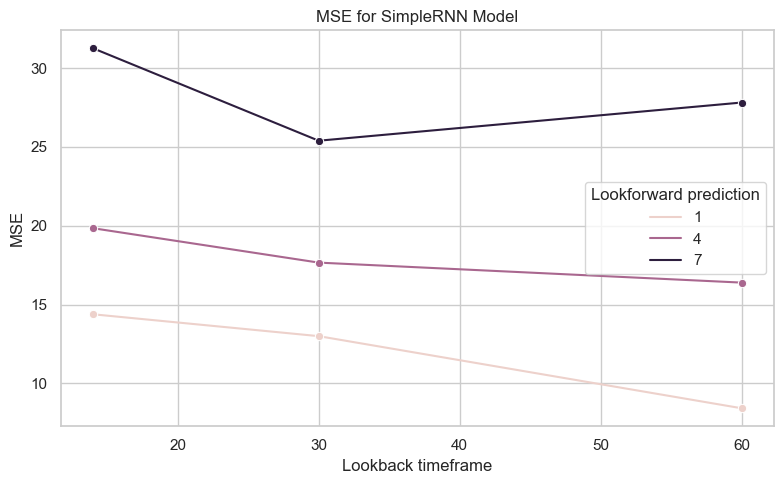

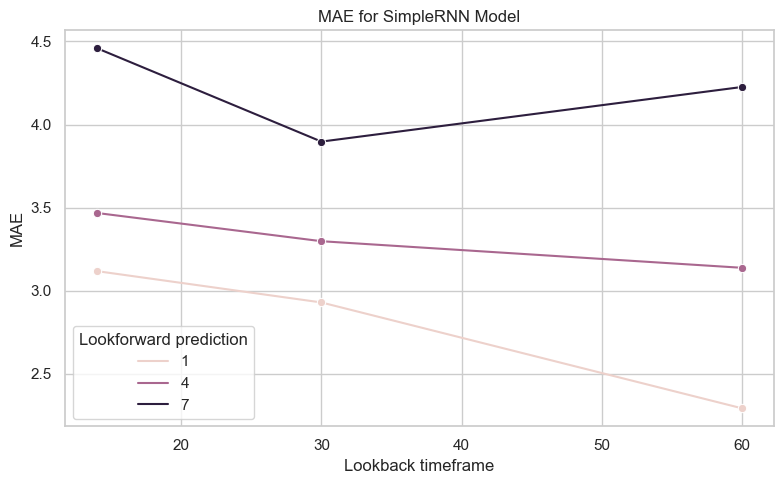

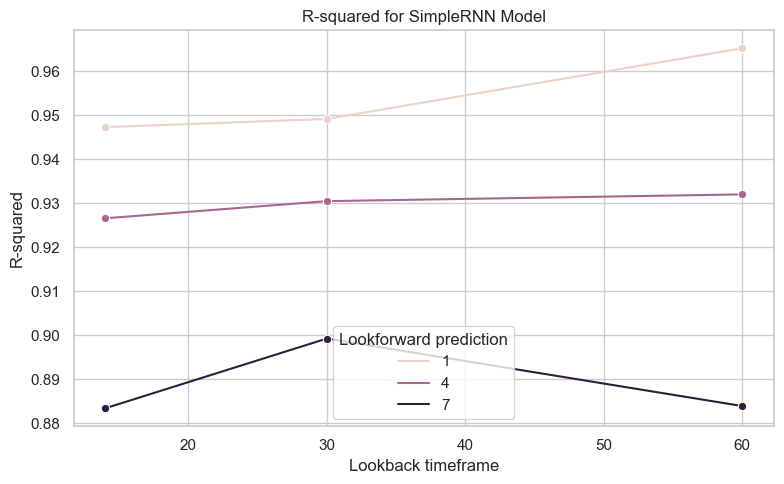

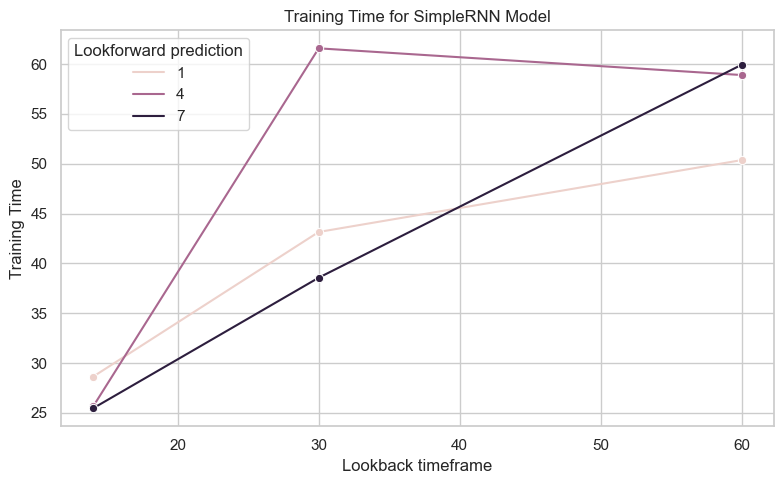

In [16]:
#Convert the MultiIndex DataFrame to a more plot-friendly format
results_simple_long = results_simple_df.T.reset_index()
results_simple_long = results_simple_long.melt(
    id_vars=["level_0", "level_1"], 
    var_name="Metric", 
    value_name="Value"
)
results_simple_long.columns = ["Lookforward", "Lookback", "Metric", "Value"]

#Filter data to plot specific metrics
metrics_to_plot = ["MSE", "MAE", "R-squared", "Training Time"]
filtered_data = results_simple_long[results_simple_long["Metric"].isin(metrics_to_plot)]

#Plot each metric
sns.set(style="whitegrid")

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=filtered_data[filtered_data["Metric"] == metric],
        x="Lookback",
        y="Value",
        hue="Lookforward",
        marker="o"
    )
    plt.title(f"{metric} for SimpleRNN Model")
    plt.xlabel("Lookback timeframe")
    plt.ylabel(metric)
    plt.legend(title="Lookforward prediction")
    plt.tight_layout()
    plt.show()
    print()

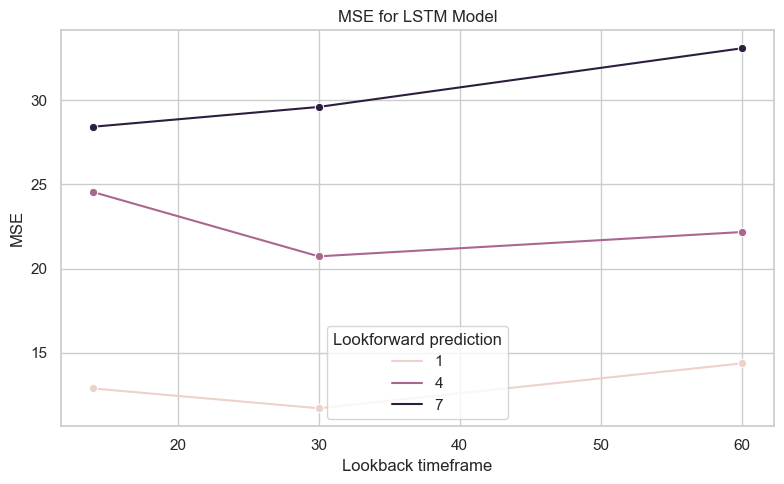

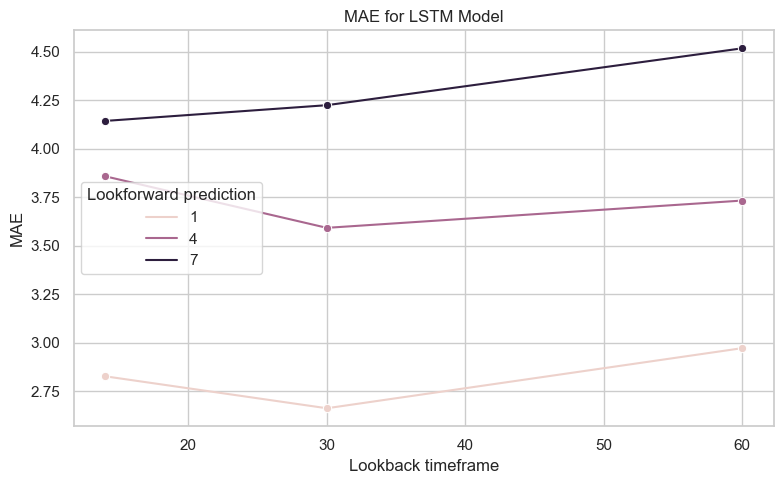

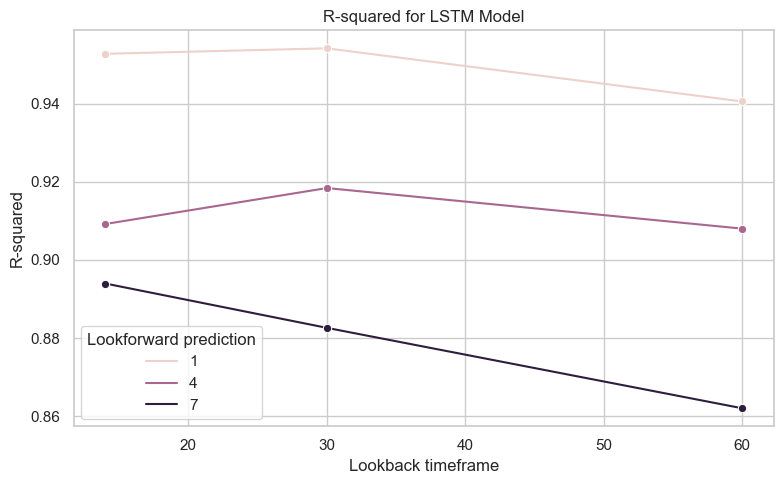

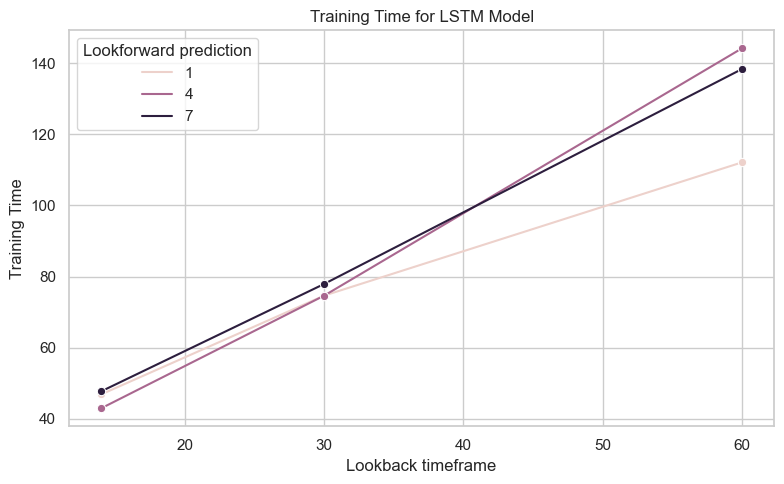

In [21]:
#Convert the MultiIndex DataFrame to a more plot-friendly format
results_LSTM_long = results_LSTM_df.T.reset_index()
results_LSTM_long = results_LSTM_long.melt(
    id_vars=["level_0", "level_1"], 
    var_name="Metric", 
    value_name="Value"
)
results_LSTM_long.columns = ["Lookforward", "Lookback", "Metric", "Value"]

#Filter data to plot specific metrics
metrics_to_plot = ["MSE", "MAE", "R-squared", "Training Time"]
filtered_data = results_LSTM_long[results_LSTM_long["Metric"].isin(metrics_to_plot)]

#Plot each metric
sns.set(style="whitegrid")

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=filtered_data[filtered_data["Metric"] == metric],
        x="Lookback",
        y="Value",
        hue="Lookforward",
        marker="o"
    )
    plt.title(f"{metric} for LSTM Model")
    plt.xlabel("Lookback timeframe")
    plt.ylabel(metric)
    plt.legend(title="Lookforward prediction")
    plt.tight_layout()
    plt.show()
    print()

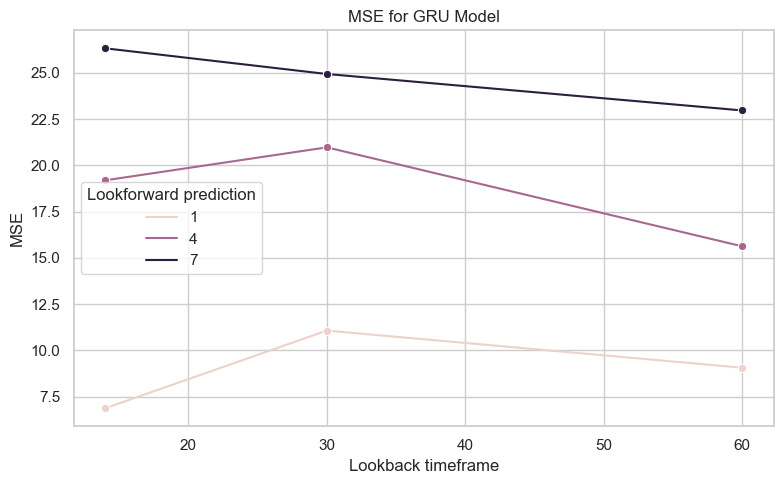

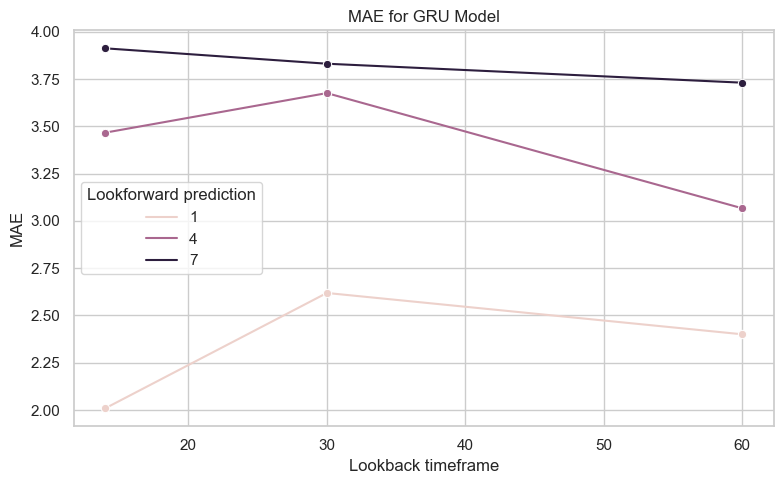

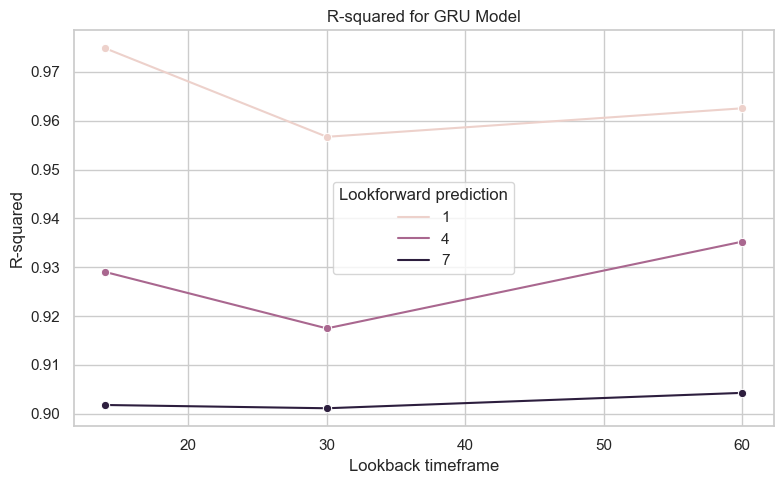

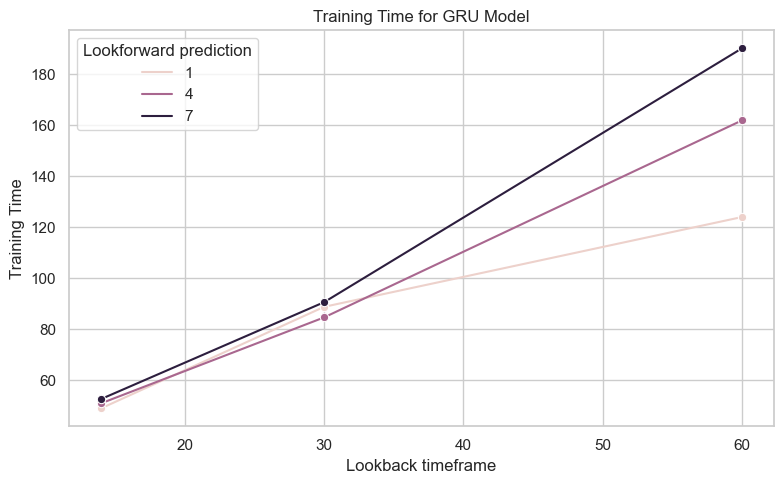

In [20]:
#Convert the MultiIndex DataFrame to a more plot-friendly format
results_GRU_long = results_GRU_df.T.reset_index()
results_GRU_long = results_GRU_long.melt(
    id_vars=["level_0", "level_1"], 
    var_name="Metric", 
    value_name="Value"
)
results_GRU_long.columns = ["Lookforward", "Lookback", "Metric", "Value"]

#Filter data to plot specific metrics
metrics_to_plot = ["MSE", "MAE", "R-squared", "Training Time"]
filtered_data = results_GRU_long[results_GRU_long["Metric"].isin(metrics_to_plot)]

#Plot each metric
sns.set(style="whitegrid")

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=filtered_data[filtered_data["Metric"] == metric],
        x="Lookback",
        y="Value",
        hue="Lookforward",
        marker="o"
    )
    plt.title(f"{metric} for GRU Model")
    plt.xlabel("Lookback timeframe")
    plt.ylabel(metric)
    plt.legend(title="Lookforward prediction")
    plt.tight_layout()
    plt.show()
    print()
